In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from matplotlib.lines import Line2D

## Evaluation RQ1

In [2]:
results_files = {
    '0.0': '/content/summary_00.csv',
    '0.25': '/content/summary_025.csv',
    '0.5': '/content/summary_05.csv',
    '0.75': '/content/summary_075.csv',
    '1.0': '/content/summary_10.csv'
}

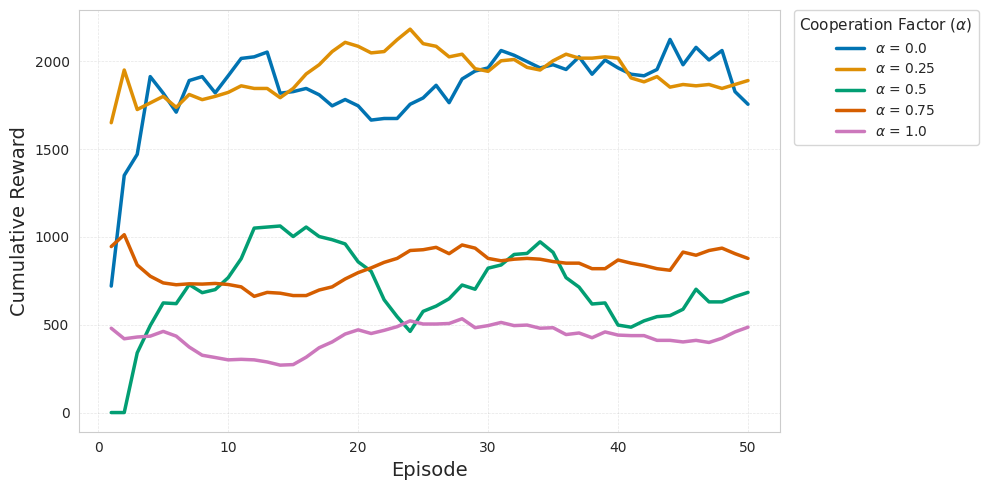

In [3]:
def plot_reward_comparison(files_dict, window_size=10):
    plt.figure(figsize=(10, 5))
    sns.set_style("whitegrid")

    # Using a categorical palette for better distinction
    # colors = sns.color_palette("tab10", len(files_dict))
    colors = sns.color_palette("colorblind", len(files_dict))

    for i, (alpha, file_path) in enumerate(files_dict.items()):
        try:
            df = pd.read_csv(file_path)
            df['reward_smooth'] = df['cumulative_reward'].rolling(window=window_size, min_periods=1).mean()

            plt.plot(df['episode'], df['reward_smooth'],
                     label=fr'$\alpha$ = {alpha}',
                     color=colors[i],
                     linewidth=2.5)

        except Exception as e:
            print(f"Error processing {alpha}: {e}")

    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Cumulative Reward', fontsize=14)

    plt.grid(visible=True, which='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.2)

    # Positioning the legend outside the plot
    # loc='upper left' determines which corner of the legend we are positioning
    # bbox_to_anchor=(1.02, 1) places it slightly to the right of the axis
    plt.legend(title=r'Cooperation Factor ($\alpha$)',
               fontsize=10,
               title_fontsize=11,
               loc='upper left',
               bbox_to_anchor=(1.02, 1),
               borderaxespad=0)

    # Adjust layout to make room for the legend on the right
    plt.tight_layout()
    plt.show()

plot_reward_comparison(results_files)

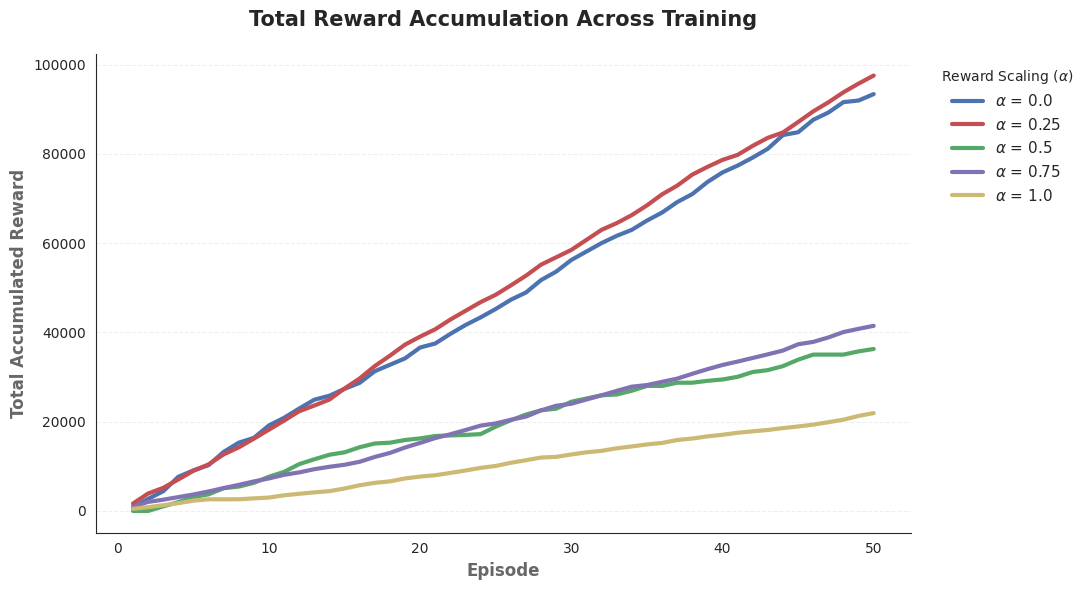

In [4]:
def plot_total_accumulation(files_dict):
    plt.figure(figsize=(11, 6))
    sns.set_style("white")
    custom_colors = ['#4C72B0', '#C44E52', '#55A868', '#8172B3', '#CCB974']

    for i, (alpha, file_path) in enumerate(files_dict.items()):
        try:
            df = pd.read_csv(file_path)

            df['total_acc'] = df['cumulative_reward'].cumsum()
            plt.plot(df['episode'], df['total_acc'],
                     label=fr'$\alpha$ = {alpha}',
                     color=custom_colors[i % len(custom_colors)],
                     linewidth=3,
                     zorder=3)

        except Exception as e:
            print(f"Error processing {alpha}: {e}")

    plt.xlabel('Episode', fontsize=12, fontweight='bold', alpha=0.7)
    plt.ylabel('Total Accumulated Reward', fontsize=12, fontweight='bold', alpha=0.7)
    plt.title('Total Reward Accumulation Across Training', fontsize=15, fontweight='bold', pad=20)

    plt.grid(axis='y', linestyle='--', alpha=0.3, zorder=0)
    sns.despine()

    plt.legend(title=r'Reward Scaling ($\alpha$)',
               frameon=False,
               loc='upper left',
               bbox_to_anchor=(1.02, 1),
               fontsize=11)

    plt.tight_layout()
    # plt.savefig('total_accumulation_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


plot_total_accumulation(results_files)

In [5]:
def load_all_data(files_dict):
    """
    Loads all summary CSV files into a single list of DataFrames.
    Adds an 'alpha' column to each DataFrame for identification.
    """
    all_data = []
    for alpha, file_path in files_dict.items():
        try:
            df = pd.read_csv(file_path)
            df['alpha'] = alpha  # Assign alpha value to the dataframe
            all_data.append(df)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    return all_data

In [6]:
def create_performance_table(all_data):
    """
    Calculates Mean ± SD for performance metrics and generates a summary table.
    Metrics: Capture Frequency and Inter-agent Collisions.
    """
    if not all_data:
        return None

    full_df = pd.concat(all_data)
    summary_list = []

    # Calculate statistics for each alpha profile
    for alpha in full_df['alpha'].unique():
        alpha_df = full_df[full_df['alpha'] == alpha]

        cap_mean, cap_std = alpha_df['total_captures'].mean(), alpha_df['total_captures'].std()
        coll_mean, coll_std = alpha_df['total_collisions'].mean(), alpha_df['total_collisions'].std()

        summary_list.append({
            "Alpha Profile": alpha,
            "Capture Frequency": f"{cap_mean:.2f} ± {cap_std:.2f}",
            "Inter-agent Collisions": f"{coll_mean:.2f} ± {coll_std:.2f}"
        })

    # Sort by alpha profile descending (from 1.0 to 0.0)
    final_table = pd.DataFrame(summary_list).sort_values(by="Alpha Profile", ascending=False)
    return final_table

In [ ]:
def plot_capture_boxplot(all_data):
    """
    Generates a clean Boxplot for Capture Frequency across different alpha values.
    Uses 'steelblue' for boxes and adds a stripplot to show the distribution.
    """
    if not all_data:
        return

    # Combine all data and sort by alpha for consistent plotting
    full_df = pd.concat(all_data).sort_values(by="alpha", ascending=False)

    # Setting visual style consistent with the project report
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    # Generate the main Boxplot
    sns.boxplot(
        x='alpha',
        y='total_captures',
        data=full_df,
        color="steelblue",
        width=0.6,
        showfliers=False  # Fliers are shown by the stripplot below
    )

    # Overlay stripplot to visualize the individual episode distribution
    sns.stripplot(
        x='alpha',
        y='total_captures',
        data=full_df,
        color=".25",
        size=4,
        alpha=0.4,
        jitter=True
    )

    # Formatting labels and title
    plt.xlabel(r'Alpha Coefficient ($\alpha$)', fontsize=14)
    plt.ylabel('Total Captures per Episode', fontsize=14)
    plt.title('Capture Frequency Distribution across Alpha Profiles', fontsize=15, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

# --- Main Execution ---
# 1. Load data from the specified files
data = load_all_data(results_files)

if data:
    # 2. Display the Boxplot for Capture Frequency
    plot_capture_boxplot(data)

    # 3. Create and display the performance summary table
    performance_table = create_performance_table(data)

    # Use display() in Jupyter/Colab for a formatted table output
    try:
        from IPython.display import display
        display(performance_table)
    except ImportError:
        print(performance_table)

## Spatial Analysis

In [8]:

def plot_alpha_comparison_single_ep(files_dict, ep_id=1):
    """
    files_dict: dict with alphas - {'0.0': 'path0.csv', '0.5': 'path05.csv', '1.0': 'path1.csv'}
    ep_id: episode number (default 1)
    """
    n_cols = len(files_dict)

    fig, axes = plt.subplots(1, n_cols, figsize=(15, 6), sharex=True, sharey=True)

    colors = {
      'adversary_0': '#377eb8',
      'adversary_1': '#4daf4a',
      'adversary_2': '#984ea3',
      'agent_0':      '#e41a1c'
    }

    for col_idx, (alpha_label, file_path) in enumerate(files_dict.items()):
        ax = axes[col_idx]

        try:
            # load and filter
            df = pd.read_csv(file_path)
            ep_df = df[df['episode id'] == ep_id]

            # label
            ax.set_title(fr"$\alpha = {alpha_label}$", fontsize=18, fontweight='bold', pad=15)

            if col_idx == 0:
                ax.set_ylabel('Y Coordinate', fontsize=12)

            ax.grid(True, linestyle=':', alpha=0.3)

            for agent_name, color in colors.items():
                agent_data = ep_df[ep_df['agent name'] == agent_name]
                if agent_data.empty: continue

                # 1. heatmap
                if agent_data['x coordinate'].nunique() > 1:
                    sns.kdeplot(
                        data=agent_data, x='x coordinate', y='y coordinate',
                        fill=True, alpha=0.4, color=color, levels=4, thresh=0.1, ax=ax
                    )
                    # 2. line
                    ax.plot(agent_data['x coordinate'], agent_data['y coordinate'],
                            color=color, alpha=0.3, linewidth=1.5, zorder=2)

                # 3. start (*)
                ax.scatter(agent_data['x coordinate'].iloc[0], agent_data['y coordinate'].iloc[0],
                           color=color, marker='*', s=200, edgecolor='white', linewidth=0.8, zorder=6)

                # 4. end (o)
                ax.scatter(agent_data['x coordinate'].iloc[-1], agent_data['y coordinate'].iloc[-1],
                           color=color, s=100, edgecolor='white', linewidth=1, zorder=5, label=agent_name)

            ax.set_xlim(-1.1, 1.1)
            ax.set_ylim(-1.1, 1.1)
            ax.set_aspect('equal')
            ax.set_xlabel('X Coordinate', fontsize=12)

        except Exception as e:
            ax.text(0.5, 0.5, f"Error loading\nAlpha {alpha_label}", ha='center', va='center', transform=ax.transAxes)
            print(f"Error in Alpha {alpha_label}: {e}")

    handles, labels = axes[0].get_legend_handles_labels()
    by_label = OrderedDict()

    clean_names = {
        'adversary_0': 'Predator 1',
        'adversary_1': 'Predator 2',
        'adversary_2': 'Predator 3',
        'agent_0': 'Prey'
    }

    agent_labels = ['adversary_0', 'adversary_1', 'adversary_2', 'agent_0']
    for agent in agent_labels:
        for h, l in zip(handles, labels):
            if agent in l:
                by_label[clean_names[agent]] = h
                break

    start_marker = Line2D([0], [0], marker='*', color='w', markerfacecolor='black',
                          markersize=15, label='Start', linestyle='None')
    end_marker = Line2D([0], [0], marker='o', color='w', markerfacecolor='black',
                        markersize=10, label='End', linestyle='None')

    by_label['Start'] = start_marker
    by_label['End'] = end_marker

    plt.tight_layout(rect=[0, 0.12, 1, 1])
    plt.subplots_adjust(wspace=0.1)

    if by_label:
        fig.legend(by_label.values(), by_label.keys(), loc='lower center',
                   bbox_to_anchor=(0.5, 0.05), ncol=len(by_label), frameon=False, fontsize=12)

    plt.show()

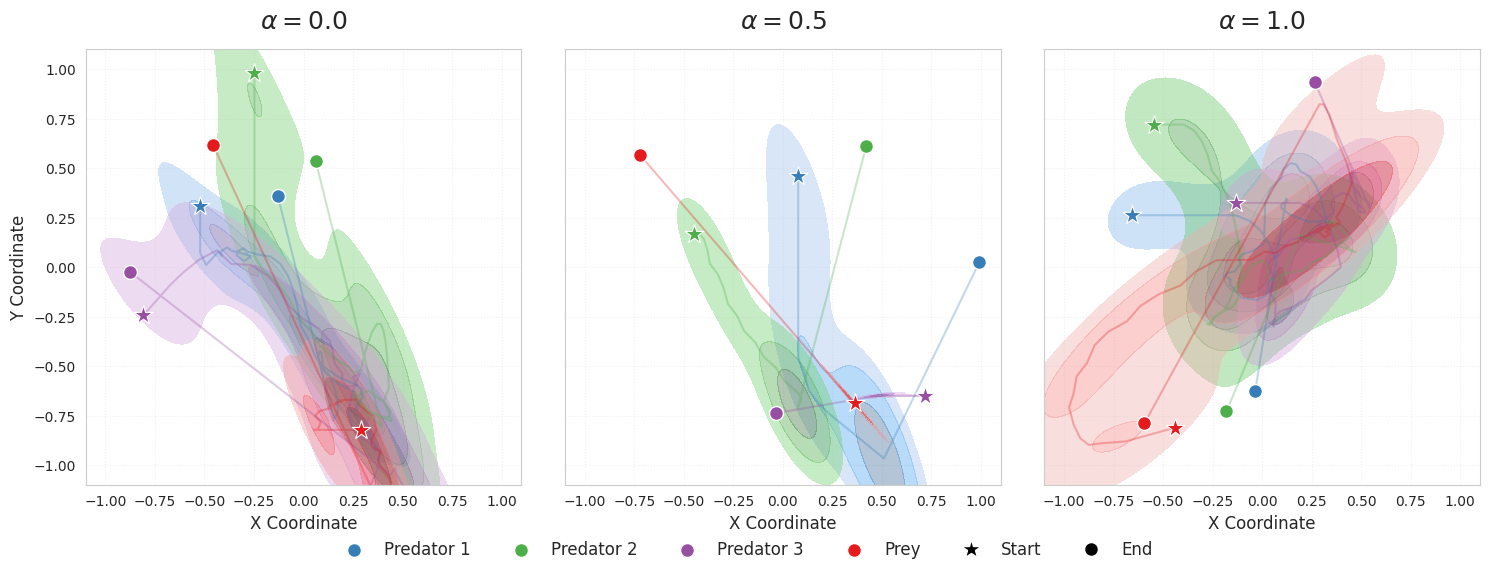

In [9]:
alpha_files_subset = {
    '0.0': 'trajectories_00.csv',
    '0.5': 'trajectories_05.csv',
    '1.0': 'trajectories_10.csv'
}
# episode 1
plot_alpha_comparison_single_ep(alpha_files_subset, ep_id=1)

In [10]:
def plot_alpha_episode_matrix(files_dict, episode_ids=[1, 25, 50]):
    """
    files_dict: dict with alphas- {'0.0': 'path1.csv', '0.25': 'path2.csv', ...}
    episode_ids: 3 episodes (default [1, 25, 50])
    """
    n_rows = len(episode_ids)
    n_cols = len(files_dict)

    # matrix
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10), sharex=True, sharey=True)

    colors = {
      'adversary_0': '#377eb8',
      'adversary_1': '#4daf4a',
      'adversary_2': '#984ea3',
      'agent_0':      '#e41a1c'
    }

    for row_idx, ep_id in enumerate(episode_ids):
        for col_idx, (alpha_label, file_path) in enumerate(files_dict.items()):
            ax = axes[row_idx, col_idx]

            try:
                df = pd.read_csv(file_path)
                ep_df = df[df['episode id'] == ep_id]

                if row_idx == 0:
                    ax.set_title(fr"$\alpha = {alpha_label}$", fontsize=16, fontweight='bold', pad=15)

                if col_idx == 0:
                    ax.set_ylabel(f"Episode {ep_id}", fontsize=16, fontweight='bold')

                ax.grid(True, linestyle=':', alpha=0.3)

                for agent_name, color in colors.items():
                    agent_data = ep_df[ep_df['agent name'] == agent_name]
                    if agent_data.empty: continue

                    # 1. heapmap
                    if agent_data['x coordinate'].nunique() > 1:
                        sns.kdeplot(
                            data=agent_data, x='x coordinate', y='y coordinate',
                            fill=True, alpha=0.4, color=color, levels=4, thresh=0.1, ax=ax
                        )
                        # 2. line
                        ax.plot(agent_data['x coordinate'], agent_data['y coordinate'],
                                color=color, alpha=0.3, linewidth=1, zorder=2)

                    # 3. start (*)
                    ax.scatter(agent_data['x coordinate'].iloc[0], agent_data['y coordinate'].iloc[0],
                               color=color, marker='*', s=150, edgecolor='white', linewidth=0.5, zorder=6)

                    # 4. end (o)
                    ax.scatter(agent_data['x coordinate'].iloc[-1], agent_data['y coordinate'].iloc[-1],
                               color=color, s=70, edgecolor='white', linewidth=1, zorder=5)

                ax.set_xlim(-1.1, 1.1)
                ax.set_ylim(-1.1, 1.1)
                ax.set_aspect('equal')

                ax.set_xlabel('')
                if col_idx > 0: ax.set_ylabel('')

            except Exception as e:
                ax.text(0, 0, f"Error\n{alpha_label}", ha='center')
                print(f"Error in Alpha {alpha_label}, Ep {ep_id}: {e}")

    handles, labels = axes[0, 0].get_legend_handles_labels()
    by_label = OrderedDict()
    agent_labels = ['adversary_0', 'adversary_1', 'adversary_2', 'agent_0']
    for h, l in zip(handles, labels):
        for agent in agent_labels:
            if agent in l and agent not in by_label:
                by_label[agent] = h

    fig.legend(by_label.values(), by_label.keys(), loc='upper center',
               bbox_to_anchor=(0.5, 0.05), ncol=4, frameon=False, fontsize=14)


    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()


In [11]:
alpha_files = {
    '0.0':  'trajectories_00.csv',
    '0.25': 'trajectories_025.csv',
    '0.5':  'trajectories_05.csv',
    '0.75': 'trajectories_075.csv',
    '1.0':  'trajectories_10.csv'
}

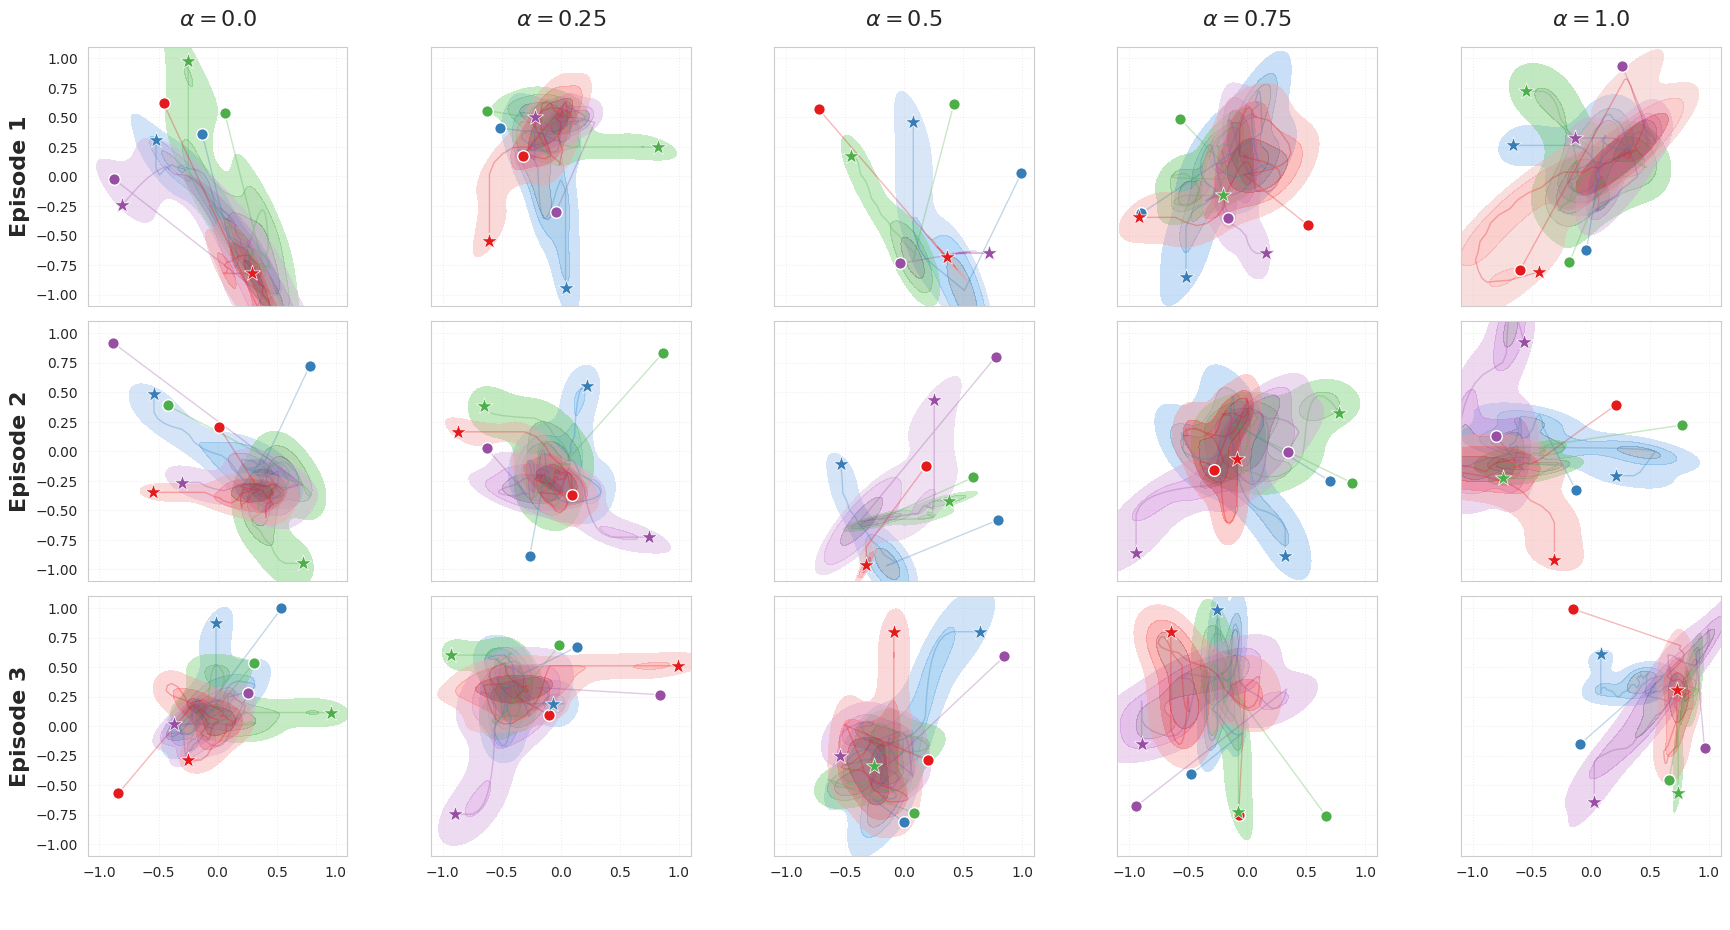

In [12]:
plot_alpha_episode_matrix(alpha_files, episode_ids=[1, 2, 3])